In [1]:
import os
from random import randint
import torch
import torchvision
from trainer.base import BaseTrainer
from utils.meters import AverageMeter
from utils.eval import predict, calc_acc, add_images_tb


class Trainer(BaseTrainer):
    def __init__(self, cfg, network, optimizer, loss, lr_scheduler, device, trainloader, testloader, writer):
        super(Trainer, self).__init__(cfg, network, optimizer, loss, lr_scheduler, device, trainloader, testloader, writer)
        self.network = self.network.to(device)
        self.train_loss_metric = AverageMeter(writer=writer, name='Loss/train', length=len(self.trainloader))
        self.train_acc_metric = AverageMeter(writer=writer, name='Accuracy/train', length=len(self.trainloader))

        self.val_loss_metric = AverageMeter(writer=writer, name='Loss/val', length=len(self.testloader))
        self.val_acc_metric = AverageMeter(writer=writer, name='Accuracy/val', length=len(self.testloader))
        self.best_val_acc = 0


    def load_model(self):
        saved_name = os.path.join(self.cfg['output_dir'], '{}_{}.pth'.format(self.cfg['model']['base'], self.cfg['dataset']['name']))
        state = torch.load(saved_name)

        self.optimizer.load_state_dict(state['optimizer'])
        self.network.load_state_dict(state['state_dict'])


    def save_model(self, epoch):
        if not os.path.exists(self.cfg['output_dir']):
            os.makedirs(self.cfg['output_dir'])

        saved_name = os.path.join(self.cfg['output_dir'], '{}_{}.pth'.format(self.cfg['model']['base'], self.cfg['dataset']['name']))

        state = {
            'epoch': epoch,
            'state_dict': self.network.state_dict(),
            'optimizer': self.optimizer.state_dict()
        }
        
        torch.save(state, saved_name)


    def train_one_epoch(self, epoch):

        self.network.train()
        self.train_loss_metric.reset(epoch)
        self.train_acc_metric.reset(epoch)

        for i, (img, mask, label) in enumerate(self.trainloader):
            img, mask, label = img.to(self.device), mask.to(self.device), label.to(self.device)
            net_mask, net_label = self.network(img)
            self.optimizer.zero_grad()
            loss = self.loss(net_mask, net_label, mask, label)
            loss.backward()
            self.optimizer.step()

            # Calculate predictions
            preds, _ = predict(net_mask, net_label, score_type=self.cfg['test']['score_type'])
            targets, _ = predict(mask, label, score_type=self.cfg['test']['score_type'])
            acc = calc_acc(preds, targets)
            # Update metrics
            self.train_loss_metric.update(loss.item())
            self.train_acc_metric.update(acc)

            print('Epoch: {}, iter: {}, loss: {}, acc: {}'.format(epoch + 1, epoch * len(self.trainloader) + i + 1, self.train_loss_metric.avg, self.train_acc_metric.avg))


    def train(self):

        for epoch in range(self.cfg['train']['num_epochs']):
            self.train_one_epoch(epoch)
            epoch_acc = self.validate(epoch)
            # if epoch_acc > self.best_val_acc:
            #     self.best_val_acc = epoch_acc
            self.save_model(epoch)


    def validate(self, epoch):
        self.network.eval()
        self.val_loss_metric.reset(epoch)
        self.val_acc_metric.reset(epoch)

        seed = randint(0, len(self.testloader)-1)

        for i, (img, mask, label) in enumerate(self.testloader):
            img, mask, label = img.to(self.device), mask.to(self.device), label.to(self.device)
            net_mask, net_label = self.network(img)
            loss = self.loss(net_mask, net_label, mask, label)

            # Calculate predictions
            preds, score = predict(net_mask, net_label, score_type=self.cfg['test']['score_type'])
            targets, _ = predict(mask, label, score_type=self.cfg['test']['score_type'])
            acc = calc_acc(preds, targets)
            # Update metrics
            self.val_loss_metric.update(loss.item())
            self.val_acc_metric.update(acc)

            
            if i == seed:
                add_images_tb(self.cfg, epoch, img, preds, targets, score, self.writer)

        return self.val_acc_metric.avg


In [2]:
import os
import torch
from torchvision import transforms, datasets
#from trainer.Trainer import Trainer
from torch.utils.tensorboard import SummaryWriter
from models.loss import PixWiseBCELoss
from datasets.PixWiseDataset import PixWiseDataset
from utils.utils import read_cfg, get_optimizer, build_network, get_device

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

cfg = read_cfg(cfg_file='config/densenet_161_adam_lr1e-3.yaml')

device = get_device(cfg)

network = build_network(cfg)

optimizer = get_optimizer(cfg, network)

loss = PixWiseBCELoss(beta=cfg['train']['loss']['beta'])

writer = SummaryWriter(cfg['log_dir'])

dump_input = torch.randn(1,3,224,224)

writer.add_graph(network, (dump_input, ))

# Without Resize transform, images are of different sizes and it causes an error
train_transform = transforms.Compose([
    transforms.Resize(cfg['model']['image_size']),
    transforms.RandomRotation(cfg['dataset']['augmentation']['rotation']),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cfg['dataset']['mean'], cfg['dataset']['sigma'])
])

test_transform = transforms.Compose([
    transforms.Resize(cfg['model']['image_size']),
    transforms.ToTensor(),
    transforms.Normalize(cfg['dataset']['mean'], cfg['dataset']['sigma'])
])

trainset = PixWiseDataset(
    root_dir=cfg['dataset']['root'],
    csv_file=cfg['dataset']['train_set'],
    map_size=cfg['model']['map_size'],
    transform=train_transform,
    smoothing=cfg['model']['smoothing']
)

testset = PixWiseDataset(
    root_dir=cfg['dataset']['root'],
    csv_file=cfg['dataset']['test_set'],
    map_size=cfg['model']['map_size'],
    transform=test_transform,
    smoothing=cfg['model']['smoothing']
)

trainloader = torch.utils.data.DataLoader(
    dataset=trainset,
    batch_size=cfg['train']['batch_size'],
    shuffle=True,
    num_workers=0
)

testloader = torch.utils.data.DataLoader(
    dataset=testset,
    batch_size=cfg['test']['batch_size'],
    shuffle=True,
    num_workers=0
)

trainer = Trainer(
    cfg=cfg,
    network=network,
    optimizer=optimizer,
    loss=loss,
    lr_scheduler=None,
    device=device,
    trainloader=trainloader,
    testloader=testloader,
    writer=writer
)

trainer.train()
writer.close()

C:\ProgramData\Anaconda3\envs\0\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
C:\ProgramData\Anaconda3\envs\0\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1, iter: 1, loss: 0.7527894973754883, acc: 0.4583333432674408
Epoch: 1, iter: 2, loss: 0.7930410802364349, acc: 0.375
Epoch: 1, iter: 3, loss: 0.7943640947341919, acc: 0.4861111044883728
Epoch: 1, iter: 4, loss: 0.7722362577915192, acc: 0.5416666567325592
Epoch: 1, iter: 5, loss: 0.7666640639305115, acc: 0.5666666626930237
Epoch: 1, iter: 6, loss: 0.7519637842973074, acc: 0.5763888855775198
Epoch: 1, iter: 7, loss: 0.7344611542565482, acc: 0.6011904733521598
Epoch: 1, iter: 8, loss: 0.7266063839197159, acc: 0.609375
Epoch: 1, iter: 9, loss: 0.7239363723331027, acc: 0.6111111111111112
Epoch: 1, iter: 10, loss: 0.7149448394775391, acc: 0.625
Epoch: 1, iter: 11, loss: 0.7105919935486533, acc: 0.6287878805940802
Epoch: 1, iter: 12, loss: 0.7066123137871424, acc: 0.6388888905445734
Epoch: 1, iter: 13, loss: 0.7061071350024297, acc: 0.637820514348837
Epoch: 1, iter: 14, loss: 0.7047214550631387, acc: 0.6398809552192688
Epoch: 1, iter: 15, loss: 0.6991948167483012, acc: 0.6444444457689

Epoch: 2, iter: 120, loss: 0.5665583506874416, acc: 0.8532608721567236
Epoch: 2, iter: 121, loss: 0.565674846371015, acc: 0.855902781089147
Epoch: 2, iter: 122, loss: 0.5639314126968383, acc: 0.856666669845581
Epoch: 2, iter: 123, loss: 0.5644901922115912, acc: 0.8573717979284433
Epoch: 2, iter: 124, loss: 0.5636905409671642, acc: 0.856481483689061
Epoch: 2, iter: 125, loss: 0.5620359693254743, acc: 0.8616071449858802
Epoch: 2, iter: 126, loss: 0.5612888027881754, acc: 0.8606321852782677
Epoch: 2, iter: 127, loss: 0.5608103315035502, acc: 0.8597222228844961
Epoch: 2, iter: 128, loss: 0.5594998559644145, acc: 0.860215054404351
Epoch: 2, iter: 129, loss: 0.5587358977645636, acc: 0.859375
Epoch: 2, iter: 130, loss: 0.5576315449945854, acc: 0.8623737367716703
Epoch: 2, iter: 131, loss: 0.5575596900547252, acc: 0.8615196066744187
Epoch: 2, iter: 132, loss: 0.5552542311804635, acc: 0.8630952375275748
Epoch: 2, iter: 133, loss: 0.5541097223758698, acc: 0.8645833333333334
Epoch: 2, iter: 134, 

Epoch: 3, iter: 237, loss: 0.510252398806949, acc: 0.8905038764310438
Epoch: 3, iter: 238, loss: 0.5113082778724757, acc: 0.8901515156030655
Epoch: 3, iter: 239, loss: 0.5102871080239614, acc: 0.8916666666666667
Epoch: 3, iter: 240, loss: 0.5088458521210629, acc: 0.8931159415970678
Epoch: 3, iter: 241, loss: 0.508390393028868, acc: 0.8918439707857497
Epoch: 3, iter: 242, loss: 0.5068529266864061, acc: 0.8923611106971899
Epoch: 3, iter: 243, loss: 0.5067722377728443, acc: 0.8920068023156147
Epoch: 3, iter: 244, loss: 0.505544371008873, acc: 0.8933333325386047
Epoch: 3, iter: 245, loss: 0.503920822166929, acc: 0.8946078419685364
Epoch: 3, iter: 246, loss: 0.5031867319574723, acc: 0.8942307680845261
Epoch: 3, iter: 247, loss: 0.501394510269165, acc: 0.8962264139697237
Epoch: 3, iter: 248, loss: 0.5009538741023453, acc: 0.8966049375357451
Epoch: 3, iter: 249, loss: 0.5000358332287181, acc: 0.8969696966084567
Epoch: 3, iter: 250, loss: 0.4990679419466427, acc: 0.8973214285714286
Epoch: 3, i

Epoch: 4, iter: 354, loss: 0.45482691649406676, acc: 0.915343909982651
Epoch: 4, iter: 355, loss: 0.45454436680302024, acc: 0.9147135363891721
Epoch: 4, iter: 356, loss: 0.45475605726242063, acc: 0.9141025589062617
Epoch: 4, iter: 357, loss: 0.45430607597033185, acc: 0.9154040352864699
Epoch: 4, iter: 358, loss: 0.4532324725122594, acc: 0.9160447707816736
Epoch: 4, iter: 359, loss: 0.45223164470756755, acc: 0.9166666611152536
Epoch: 4, iter: 360, loss: 0.4531939038331958, acc: 0.9154589314391648
Epoch: 4, iter: 361, loss: 0.45244339917387283, acc: 0.9154761850833892
Epoch: 4, iter: 362, loss: 0.45151046422165886, acc: 0.9166666613498204
Epoch: 4, iter: 363, loss: 0.4502161637776428, acc: 0.9178240688310729
Epoch: 4, iter: 364, loss: 0.4496335905708679, acc: 0.9178082142790703
Epoch: 4, iter: 365, loss: 0.44941180179247986, acc: 0.9177927882284731
Epoch: 4, iter: 366, loss: 0.4515652104218801, acc: 0.916666661898295
Epoch: 4, iter: 367, loss: 0.45230572827552495, acc: 0.9161184163470018

Epoch: 5, iter: 470, loss: 0.4196362953360488, acc: 0.9202235733590475
Epoch: 5, iter: 471, loss: 0.4186788097203496, acc: 0.9206827268543014
Epoch: 5, iter: 472, loss: 0.41848270559594747, acc: 0.9206349168504987
Epoch: 5, iter: 473, loss: 0.4179677840541391, acc: 0.921078427398906
Epoch: 5, iter: 474, loss: 0.4180253834225411, acc: 0.9200581353764201
Epoch: 5, iter: 475, loss: 0.4185330590297436, acc: 0.9195402257743923
Epoch: 5, iter: 476, loss: 0.41768814250826836, acc: 0.9195075719193979
Epoch: 5, iter: 477, loss: 0.4170027328341195, acc: 0.9204119812236743
Epoch: 5, iter: 478, loss: 0.4167555338806576, acc: 0.9203703668382432
Epoch: 5, iter: 479, loss: 0.4162980494918404, acc: 0.9212454177521088
Epoch: 5, iter: 480, loss: 0.41576872020959854, acc: 0.9216485470533371
Epoch: 5, iter: 481, loss: 0.41520421543428976, acc: 0.9220430069072272
Epoch: 5, iter: 482, loss: 0.41389927204619065, acc: 0.9228723366209801
Epoch: 5, iter: 483, loss: 0.4141006538742467, acc: 0.9228070139884949
Ep

Epoch: 7, iter: 586, loss: 0.3196141943335533, acc: 0.96875
Epoch: 7, iter: 587, loss: 0.32387712597846985, acc: 0.9666666626930237
Epoch: 7, iter: 588, loss: 0.322371040781339, acc: 0.972222218910853
Epoch: 7, iter: 589, loss: 0.3170433299882071, acc: 0.9702380895614624
Epoch: 7, iter: 590, loss: 0.31997984647750854, acc: 0.9687499925494194
Epoch: 7, iter: 591, loss: 0.3468475937843323, acc: 0.9490740696589152
Epoch: 7, iter: 592, loss: 0.350449675321579, acc: 0.9333333313465119
Epoch: 7, iter: 593, loss: 0.3419508825648915, acc: 0.939393937587738
Epoch: 7, iter: 594, loss: 0.3417217681805293, acc: 0.9375
Epoch: 7, iter: 595, loss: 0.34539809823036194, acc: 0.9326923076923077
Epoch: 7, iter: 596, loss: 0.360110872558185, acc: 0.9255952366760799
Epoch: 7, iter: 597, loss: 0.36398277084032693, acc: 0.9194444417953491
Epoch: 7, iter: 598, loss: 0.36426431871950626, acc: 0.9218749962747097
Epoch: 7, iter: 599, loss: 0.3612184769967023, acc: 0.9264705847291386
Epoch: 7, iter: 600, loss: 0.

Epoch: 8, iter: 702, loss: 0.31838052169136377, acc: 0.9547101414721945
Epoch: 8, iter: 703, loss: 0.3184092938899994, acc: 0.9548611069718996
Epoch: 8, iter: 704, loss: 0.3164078378677368, acc: 0.9566666626930237
Epoch: 8, iter: 705, loss: 0.3169080294095553, acc: 0.9551282020715567
Epoch: 8, iter: 706, loss: 0.3193630476792653, acc: 0.9506172802713182
Epoch: 8, iter: 707, loss: 0.3214553679738726, acc: 0.9508928528853825
Epoch: 8, iter: 708, loss: 0.3200970168771415, acc: 0.9511494204915804
Epoch: 8, iter: 709, loss: 0.31950374841690066, acc: 0.9513888835906983
Epoch: 8, iter: 710, loss: 0.3195471830906407, acc: 0.95026881271793
Epoch: 8, iter: 711, loss: 0.3192580183967948, acc: 0.9505208283662796
Epoch: 8, iter: 712, loss: 0.3165796823573835, acc: 0.952020197203665
Epoch: 8, iter: 713, loss: 0.31549276762148915, acc: 0.9522058770937079
Epoch: 8, iter: 714, loss: 0.3160234842981611, acc: 0.9511904716491699
Epoch: 8, iter: 715, loss: 0.3148392223649555, acc: 0.9525462918811374
Epoch:

Epoch: 9, iter: 818, loss: 0.2909990070121629, acc: 0.9583333333333334
Epoch: 9, iter: 819, loss: 0.2896163619534914, acc: 0.9593023255813954
Epoch: 9, iter: 820, loss: 0.28839828581972554, acc: 0.9602272727272727
Epoch: 9, iter: 821, loss: 0.28798247542646194, acc: 0.9601851847436693
Epoch: 9, iter: 822, loss: 0.28803343649791635, acc: 0.9592391304347826
Epoch: 9, iter: 823, loss: 0.28846393335372844, acc: 0.9601063829787234
Epoch: 9, iter: 824, loss: 0.2905819934482376, acc: 0.9592013893028101
Epoch: 9, iter: 825, loss: 0.29366127660079877, acc: 0.9574829936027527
Epoch: 9, iter: 826, loss: 0.29462080329656604, acc: 0.9566666674613953
Epoch: 9, iter: 827, loss: 0.29369420631259097, acc: 0.9566993467948016
Epoch: 9, iter: 828, loss: 0.29293554104291475, acc: 0.9567307692307693
Epoch: 9, iter: 829, loss: 0.2918022325578726, acc: 0.9575471698113207
Epoch: 9, iter: 830, loss: 0.2967650266709151, acc: 0.9544753090099052
Epoch: 9, iter: 831, loss: 0.2955651044845581, acc: 0.955303030664270

Epoch: 10, iter: 933, loss: 0.27392017990350725, acc: 0.9638888875643412
Epoch: 10, iter: 934, loss: 0.27367107887737085, acc: 0.9644808730141061
Epoch: 10, iter: 935, loss: 0.2727817205652114, acc: 0.9650537621590399
Epoch: 10, iter: 936, loss: 0.2720744548335908, acc: 0.9656084643469917
Epoch: 10, iter: 937, loss: 0.2711525857448578, acc: 0.9661458320915699
Epoch: 10, iter: 938, loss: 0.2703566294450026, acc: 0.9666666654440073
Epoch: 10, iter: 939, loss: 0.26943280186617014, acc: 0.9671717159675829
Epoch: 10, iter: 940, loss: 0.2692596420868119, acc: 0.9676616903561265
Epoch: 10, iter: 941, loss: 0.269198644468013, acc: 0.9675245083430234
Epoch: 10, iter: 942, loss: 0.26955521689808887, acc: 0.966787438461746
Epoch: 10, iter: 943, loss: 0.26900734709841867, acc: 0.9672619036265782
Epoch: 10, iter: 944, loss: 0.26852271905247593, acc: 0.9677230035754997
Epoch: 10, iter: 945, loss: 0.2686676103621721, acc: 0.9675925912128555
Epoch: 10, iter: 946, loss: 0.2675824465408717, acc: 0.96803

Epoch: 11, iter: 1046, loss: 0.26685215689634023, acc: 0.9627192945856797
Epoch: 11, iter: 1047, loss: 0.26627725943342434, acc: 0.9632034595910605
Epoch: 11, iter: 1048, loss: 0.2655102060391353, acc: 0.9636752101091238
Epoch: 11, iter: 1049, loss: 0.2652007224439066, acc: 0.964135017576097
Epoch: 11, iter: 1050, loss: 0.26651288419961927, acc: 0.9635416634380818
Epoch: 11, iter: 1051, loss: 0.2659789603433491, acc: 0.9639917663585993
Epoch: 11, iter: 1052, loss: 0.26530090846666476, acc: 0.9644308911591042
Epoch: 11, iter: 1053, loss: 0.2651856218475893, acc: 0.9643574263676103
Epoch: 11, iter: 1054, loss: 0.2658936892236982, acc: 0.9632936474822816
Epoch: 11, iter: 1055, loss: 0.26545878140365375, acc: 0.9627450950005475
Epoch: 11, iter: 1056, loss: 0.26583576462296554, acc: 0.9626937952152518
Epoch: 11, iter: 1057, loss: 0.2658405202901226, acc: 0.9626436747353653
Epoch: 11, iter: 1058, loss: 0.26534069617363537, acc: 0.9630681784315542
Epoch: 11, iter: 1059, loss: 0.26445332403933

Epoch: 12, iter: 1158, loss: 0.2330654026060314, acc: 0.9766483490283673
Epoch: 12, iter: 1159, loss: 0.2328064501609491, acc: 0.9764492725548537
Epoch: 12, iter: 1160, loss: 0.23284223787887123, acc: 0.9767025061832961
Epoch: 12, iter: 1161, loss: 0.232917032818845, acc: 0.9765070892394857
Epoch: 12, iter: 1162, loss: 0.23316680459599745, acc: 0.9767543830369648
Epoch: 12, iter: 1163, loss: 0.23276830169682702, acc: 0.9769965248803297
Epoch: 12, iter: 1164, loss: 0.23310042733384162, acc: 0.9762964672649029
Epoch: 13, iter: 1165, loss: 0.2133173942565918, acc: 1.0
Epoch: 13, iter: 1166, loss: 0.24824121594429016, acc: 0.9791666567325592
Epoch: 13, iter: 1167, loss: 0.2614864110946655, acc: 0.9722222089767456
Epoch: 13, iter: 1168, loss: 0.2705765664577484, acc: 0.9687499850988388
Epoch: 13, iter: 1169, loss: 0.27337695360183717, acc: 0.9666666507720947
Epoch: 13, iter: 1170, loss: 0.2710868219534556, acc: 0.965277761220932
Epoch: 13, iter: 1171, loss: 0.264158947127206, acc: 0.9702380

Epoch: 14, iter: 1271, loss: 0.2062214970588684, acc: 0.9791666626930237
Epoch: 14, iter: 1272, loss: 0.20512438091364774, acc: 0.9772727218541232
Epoch: 14, iter: 1273, loss: 0.20553229997555414, acc: 0.979166661699613
Epoch: 14, iter: 1274, loss: 0.22205891746741074, acc: 0.974358971302326
Epoch: 14, iter: 1275, loss: 0.22326670374189103, acc: 0.970238093818937
Epoch: 14, iter: 1276, loss: 0.2202989826599757, acc: 0.9722222208976745
Epoch: 14, iter: 1277, loss: 0.22059480007737875, acc: 0.9713541641831398
Epoch: 14, iter: 1278, loss: 0.2223887101692312, acc: 0.970588231787962
Epoch: 14, iter: 1279, loss: 0.22033064398500654, acc: 0.972222218910853
Epoch: 14, iter: 1280, loss: 0.2230422041918102, acc: 0.9714912238873934
Epoch: 14, iter: 1281, loss: 0.22055736631155015, acc: 0.9729166626930237
Epoch: 14, iter: 1282, loss: 0.22015988259088426, acc: 0.9722222174916949
Epoch: 14, iter: 1283, loss: 0.21908151561563666, acc: 0.9734848439693451
Epoch: 14, iter: 1284, loss: 0.2166061142216558

Epoch: 15, iter: 1384, loss: 0.22294219296712142, acc: 0.9679487164203937
Epoch: 15, iter: 1385, loss: 0.22182499368985495, acc: 0.9691358009974161
Epoch: 15, iter: 1386, loss: 0.2207776414496558, acc: 0.970238093818937
Epoch: 15, iter: 1387, loss: 0.2188083565440671, acc: 0.9712643664458702
Epoch: 15, iter: 1388, loss: 0.22127770831187565, acc: 0.9694444437821707
Epoch: 15, iter: 1389, loss: 0.22189692191539273, acc: 0.969086020223556
Epoch: 15, iter: 1390, loss: 0.22100322553887963, acc: 0.9687499981373549
Epoch: 15, iter: 1391, loss: 0.22181839337854675, acc: 0.9696969678907683
Epoch: 15, iter: 1392, loss: 0.21993669473073063, acc: 0.9705882335410398
Epoch: 15, iter: 1393, loss: 0.21887088247707912, acc: 0.9714285697255816
Epoch: 15, iter: 1394, loss: 0.22006966256433064, acc: 0.9710648126072354
Epoch: 15, iter: 1395, loss: 0.21896897941022306, acc: 0.9718468446989317
Epoch: 15, iter: 1396, loss: 0.2171367430373242, acc: 0.9725877172068546
Epoch: 15, iter: 1397, loss: 0.215982293089

In [3]:
import numpy as np

'''
labels = []
scores = []

for img, mask, label in val_dl:
    net_mask, net_label = model(img)
    pred, score = predict(net_mask, net_label)
    labels.extend(label.tolist())
    scores.extend(score.tolist())
labels = np.array(labels)
scores = np.array(scores)
'''
labels = []
scores = []

for i, (img, mask, label) in enumerate(testloader):
    img, mask, label = img.to(device), mask.to(device), label.to(device)
    net_mask, net_label = network(img)
    preds, score = predict(net_mask, net_label, score_type=cfg['test']['score_type'])
    labels.extend(label.tolist())
    scores.extend(score.tolist())
labels = np.array(labels)
scores = np.array(scores)

0.4084402322769165
0.017879948914431672


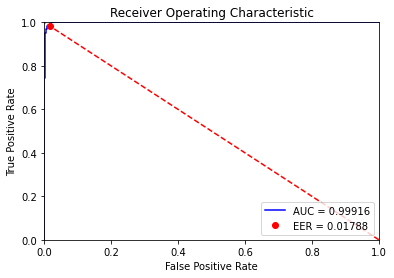

In [4]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(labels, scores, pos_label=1)
roc_auc = auc(fpr, tpr)

# рассчитываем значение EER - при котором доля ошибок первого и второго рода примерно равны
fnr = 1 - tpr
eer_threshold = thresholds[np.nanargmin(np.absolute((fnr - fpr)))]
eer = fpr[np.nanargmin(np.absolute(fnr - fpr))]

print(eer_threshold)
print(eer)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.05f' % roc_auc)
plt.plot(eer,1 - eer, 'ro', label = 'EER = %0.05f' % eer)
plt.legend(loc = 'lower right')
plt.plot([1, 0], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [5]:
from sklearn.metrics import confusion_matrix

y_pred = (scores >= eer_threshold).astype(np.float32)

# формулы расчета метрик https://sites.google.com/qq.com/face-anti-spoofing/evaluation
tn, fp, fn, tp = confusion_matrix(labels, y_pred).ravel()

apcer = fp/(tn + fp)
bpcer = fn/(fn + tp)
acer = (apcer + bpcer) / 2.0
frr = fn/(fn + tp)
far = fp/(fp + tn)
hter = (frr + far) / 2.0

print('APCER', apcer) 
print('BPCER', bpcer)     
print('ACER', acer)
print('FRR', frr)
print('FAR', far)
print('HTER', hter)

APCER 0.017879948914431672
BPCER 0.016129032258064516
ACER 0.017004490586248096
FRR 0.016129032258064516
FAR 0.017879948914431672
HTER 0.017004490586248096


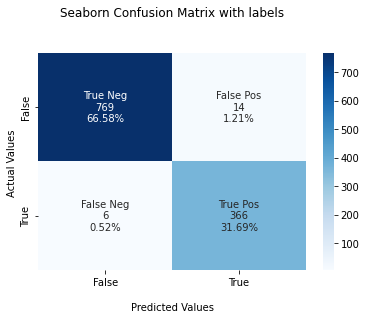

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


cf_matrix = confusion_matrix(labels, y_pred)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [7]:
import torch
from torchvision import transforms
import numpy as np
from PIL import ImageDraw


# https://gitlab.idiap.ch/bob/bob.paper.deep_pix_bis_pad.icb2019/blob/master/bob/paper/deep_pix_bis_pad/icb2019/extractor/DeepPixBiS.py
def predict(mask, label, threshold=0.5, score_type='combined'):
    with torch.no_grad():
        if score_type == 'pixel':
            score = torch.mean(mask, axis=(1,2,3))
        elif score_type == 'binary':
            score = torch.mean(label, axis=1)
        elif score_type == 'combined':
            score = torch.mean(mask, axis=(1,2)) + torch.mean(label, axis=1)
        else:
            raise NotImplementedError

        preds = (score > threshold).type(torch.FloatTensor)

        return preds, score
    

def calc_acc(pred, target):
    equal = torch.mean(pred.eq(target).type(torch.FloatTensor))
    return equal.item()


def add_images_tb(cfg, epoch, img_batch, preds, targets, score, writer):
    """ Do the inverse transformation
    x = z*sigma + mean
      = (z + mean/sigma) * sigma
      = (z - (-mean/sigma)) / (1/sigma),
    Ref: https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821/6
    """
    mean = [-cfg['dataset']['mean'][i] / cfg['dataset']['sigma'][i] for i in range(len(cfg['dataset']['mean']))]
    sigma = [1 / cfg['dataset']['sigma'][i] for i in range(len(cfg['dataset']['sigma']))]
    img_transform = transforms.Compose([
        transforms.Normalize(mean, sigma),
        transforms.ToPILImage()
    ])

    ts_transform = transforms.ToTensor()

    for idx in range(img_batch.shape[0]):
        vis_img = img_transform(img_batch[idx].cpu())
        ImageDraw.Draw(vis_img).text((0,0), 'pred: {} vs gt: {}'.format(int(preds[idx]), int(targets[idx])), (255,0,255))
        ImageDraw.Draw(vis_img).text((20,20), 'score {}'.format(score[idx]), (255,0,255))
        tb_img = ts_transform(vis_img)
        writer.add_image('Prediction visualization/{}'.format(idx), tb_img, epoch)